In [1]:
# impoting the libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas_datareader.data as web
import datetime as dt
import sklearn
#import mpld3
%matplotlib notebook
#mpld3.enable_notebook()
style.use('ggplot')

In [2]:
# asigning the start date and end date 
start = dt.datetime(1985, 1, 1) # collect from this date
end = dt.datetime.today() #to this date.
stock  = 'AAPL' #using Apple's stock data
df = web.DataReader(stock,'yahoo',start,end) #fetches the data from Yahoo and stores it in data.

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1985-01-02,0.520089,0.497768,0.520089,0.497768,43825600.0,0.022481
1985-01-03,0.520089,0.506696,0.506696,0.506696,41652800.0,0.022884
1985-01-04,0.508929,0.500000,0.506696,0.506696,34316800.0,0.022884
1985-01-07,0.508929,0.504464,0.506696,0.504464,42728000.0,0.022783
1985-01-08,0.508929,0.500000,0.504464,0.500000,35280000.0,0.022581


In [4]:
df = df.rename(columns = {'Adj Close':'adj_close'})

In [5]:
df.head()

,High,Low,Open,Close,Volume,adj_close
Date,,,,,,
1985-01-02,0.520089,0.497768,0.520089,0.497768,43825600.0,0.022481
1985-01-03,0.520089,0.506696,0.506696,0.506696,41652800.0,0.022884
1985-01-04,0.508929,0.500000,0.506696,0.506696,34316800.0,0.022884
1985-01-07,0.508929,0.504464,0.506696,0.504464,42728000.0,0.022783
1985-01-08,0.508929,0.500000,0.504464,0.500000,35280000.0,0.022581


In [6]:
df.to_csv('AAPL.csv')

In [7]:
data = pd.read_csv('AAPL.csv', parse_dates=True, index_col=0)

In [8]:
data.head()

,High,Low,Open,Close,Volume,adj_close
Date,,,,,,
1985-01-02,0.520089,0.497768,0.520089,0.497768,43825600.0,0.022481
1985-01-03,0.520089,0.506696,0.506696,0.506696,41652800.0,0.022884
1985-01-04,0.508929,0.500000,0.506696,0.506696,34316800.0,0.022884
1985-01-07,0.508929,0.504464,0.506696,0.504464,42728000.0,0.022783
1985-01-08,0.508929,0.500000,0.504464,0.500000,35280000.0,0.022581


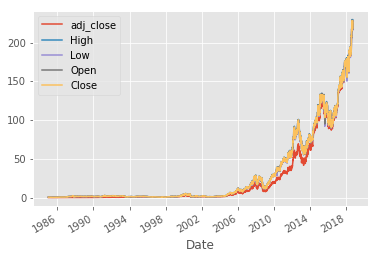

In [9]:
data[['adj_close','High','Low','Open','Close']].plot()

In [10]:
#creating a new column to add rolling average
data['100ma'] = data['adj_close'].rolling(window=100).mean()

In [11]:
data.tail()

,High,Low,Open,Close,Volume,adj_close,100ma
Date,,,,,,,
2018-09-25,222.820007,219.699997,219.750000,222.190002,24554400.0,222.190002,199.232063
2018-09-26,223.750000,219.759995,221.000000,220.419998,23984700.0,220.419998,199.611424
2018-09-27,226.440002,223.539993,223.820007,224.949997,30181200.0,224.949997,200.022883
2018-09-28,225.839996,224.020004,224.789993,225.740005,22889300.0,225.740005,200.433407
2018-10-01,229.419998,227.410004,227.949997,227.869995,13984339.0,227.869995,200.852227


In [12]:
#THe first 100 rows cant have the calculation.
data.head()

,High,Low,Open,Close,Volume,adj_close,100ma
Date,,,,,,,
1985-01-02,0.520089,0.497768,0.520089,0.497768,43825600.0,0.022481,NaN
1985-01-03,0.520089,0.506696,0.506696,0.506696,41652800.0,0.022884,NaN
1985-01-04,0.508929,0.500000,0.506696,0.506696,34316800.0,0.022884,NaN
1985-01-07,0.508929,0.504464,0.506696,0.504464,42728000.0,0.022783,NaN
1985-01-08,0.508929,0.500000,0.504464,0.500000,35280000.0,0.022581,NaN


In [13]:
data.dropna(inplace=True)

In [14]:
#the first 100 rows will be deleted due to dropna
data.head()

,High,Low,Open,Close,Volume,adj_close,100ma
Date,,,,,,,
1985-05-23,0.366071,0.352679,0.366071,0.352679,59791200.0,0.015928,0.019762
1985-05-24,0.352679,0.323661,0.352679,0.323661,147369600.0,0.014617,0.019683
1985-05-28,0.319196,0.301339,0.319196,0.301339,127741600.0,0.013609,0.019590
1985-05-29,0.308036,0.305804,0.305804,0.305804,61639200.0,0.013811,0.019500
1985-05-30,0.319196,0.314732,0.314732,0.314732,78730400.0,0.014214,0.019414


In [15]:
data.tail()

,High,Low,Open,Close,Volume,adj_close,100ma
Date,,,,,,,
2018-09-25,222.820007,219.699997,219.750000,222.190002,24554400.0,222.190002,199.232063
2018-09-26,223.750000,219.759995,221.000000,220.419998,23984700.0,220.419998,199.611424
2018-09-27,226.440002,223.539993,223.820007,224.949997,30181200.0,224.949997,200.022883
2018-09-28,225.839996,224.020004,224.789993,225.740005,22889300.0,225.740005,200.433407
2018-10-01,229.419998,227.410004,227.949997,227.869995,13984339.0,227.869995,200.852227


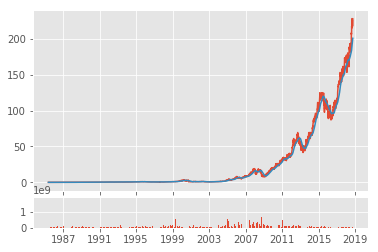

In [16]:
#visualiziation
ax1 = plt.subplot2grid((6,1), (0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0),rowspan=1,colspan=1)

ax1.plot(data.index,data['adj_close'])
ax1.plot(data.index,data['100ma'])
ax2.bar(data.index,data['Volume'])

plt.show();

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']
